In [10]:
import numpy as np
import pandas as pd

In [11]:
data = pd.read_csv('twitter_train.csv')

In [12]:
data.head(4)

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567900433542488064,negative,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada)
1,569989168903819264,positive,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)
2,568089179520954368,positive,United,NaN,LocalKyle,NaN,0,@united Flew ORD to Miami and back and had gr...,NaN,2015-02-18 08:46:29 -0800,Illinois,Central Time (US & Canada)
3,568928195581513728,negative,Southwest,NaN,amccarthy19,NaN,0,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN,2015-02-20 16:20:26 -0800,NaN,Atlantic Time (Canada)


In [13]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')

In [14]:

for col in data.columns:
    if col not in ('text', 'airline_sentiment'):
        data.drop(col,axis=1,inplace=True)

In [15]:
data.head(10)

,airline_sentiment,text
0,negative,"@SouthwestAir I am scheduled for the morning, ..."
1,positive,@SouthwestAir seeing your workers time in and ...
2,positive,@united Flew ORD to Miami and back and had gr...
3,negative,@SouthwestAir @dultch97 that's horse radish 😤🐴
4,negative,@united so our flight into ORD was delayed bec...
5,negative,@united Why did you load us in this flying sar...
6,negative,@JetBlue that is a stock response. Delays not ...
7,positive,@JetBlue That'd be nice! Hoping to rack up eno...
8,negative,@united frankly worse customer service ever. P...
9,positive,@SouthwestAir yeah haha. Never been in one. It...


In [16]:
def funct(s):
    if s=='positive':
        return 1
    if s=='negative':
        return -1
    if s=='neutral':
        return 0

In [17]:
data['airline_sentiment']=data['airline_sentiment'].apply(funct)

In [18]:
print('negative\n',data[data['airline_sentiment']==-1].count())
print('neutral\n',data[data['airline_sentiment']==0].count())
print('positive\n',data[data['airline_sentiment']==1].count())

negative
 airline_sentiment    6851
text                 6851
dtype: int64
neutral
 airline_sentiment    2327
text                 2327
dtype: int64
positive
 airline_sentiment    1802
text                 1802
dtype: int64


Here, we see that, there is huge difference between negative, positive and neutral data so we need to have almost similar no. of samples for best predictions

In [19]:
texts = data.text

In [20]:
sentiments = data.airline_sentiment
sentiments[0:10]

0   -1
1    1
2    1
3   -1
4   -1
5   -1
6   -1
7    1
8   -1
9    1
Name: airline_sentiment, dtype: int64

In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Tokenize the data
list_tokens = [word_tokenize(i) for i in texts]

# Define stop words and punctuation
punc = set(string.punctuation)
stop_words = set(stopwords.words('english'))
stop_words.update(punc)

# Remove stop words and punctuation
list_tokens = [[word for word in sublist if word.lower() not in stop_words and word.isalnum()] for sublist in list_tokens]


In [23]:
list_tokens[0:3]

[['SouthwestAir',
  'scheduled',
  'morning',
  '2',
  'days',
  'fact',
  'yes',
  'sure',
  'evening',
  'flight',
  'one',
  'Cancelled',
  'Flightled'],
 ['SouthwestAir',
  'seeing',
  'workers',
  'time',
  'time',
  'going',
  'beyond',
  'love',
  'flying',
  'guys',
  'Thank'],
 ['united',
  'Flew',
  'ORD',
  'Miami',
  'back',
  'great',
  'crew',
  'service',
  'legs',
  'THANKS']]

In [24]:
clean_doc = []
for doc in list_tokens:
    clean = [lemmatizer.lemmatize(word.lower()) for word in doc]
    clean_doc.append(clean)

In [25]:
clean_doc[0:3]

[['southwestair',
  'scheduled',
  'morning',
  '2',
  'day',
  'fact',
  'yes',
  'sure',
  'evening',
  'flight',
  'one',
  'cancelled',
  'flightled'],
 ['southwestair',
  'seeing',
  'worker',
  'time',
  'time',
  'going',
  'beyond',
  'love',
  'flying',
  'guy',
  'thank'],
 ['united',
  'flew',
  'ord',
  'miami',
  'back',
  'great',
  'crew',
  'service',
  'leg',
  'thanks']]

In [26]:
clean_doc = [" ".join(words) for words in clean_doc]


In [27]:
clean_doc[0:10]

['southwestair scheduled morning 2 day fact yes sure evening flight one cancelled flightled',
 'southwestair seeing worker time time going beyond love flying guy thank',
 'united flew ord miami back great crew service leg thanks',
 'southwestair dultch97 horse radish',
 'united flight ord delayed air force one last flight sbn 5 min landed',
 'united load u flying sardine knew pilot 2 hour late flight incompetent beyond belief',
 'jetblue stock response delay frustrating poor cust serv amp told 3 ppl wait amp come back',
 'jetblue nice hoping rack enough mile take trip seattle enjoy perfect latte city coffee',
 'united frankly worse customer service ever problem happen deal defines company never united',
 'southwestair yeah haha never one expensive much fun destinationdragons']

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
xtr,xts,ytr,yts = train_test_split(clean_doc, sentiments, random_state=1, test_size=0.3)

In [29]:
tfidf = TfidfVectorizer(ngram_range=(1,3),min_df=8)

In [31]:

x_train = tfidf.fit_transform(xtr)

x_test = tfidf.transform(xts)
ytr[0:10]

942      1
1213    -1
3942     0
1944     0
1090     1
9997     1
9031     1
10879   -1
2444    -1
3782    -1
Name: airline_sentiment, dtype: int64

In [390]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, ytr)




In [391]:
from sklearn import naive_bayes
nb = naive_bayes.MultinomialNB()
nb.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [392]:
nb.score(x_test,yts)

0.7367941712204007

In [393]:
from sklearn.metrics import classification_report as cr
print(cr(yts, nb.predict(x_test)))

              precision    recall  f1-score   support

          -1       0.86      0.79      0.83      2034
           0       0.53      0.61      0.57       679
           1       0.62      0.70      0.66       581

    accuracy                           0.74      3294
   macro avg       0.67      0.70      0.68      3294
weighted avg       0.75      0.74      0.74      3294



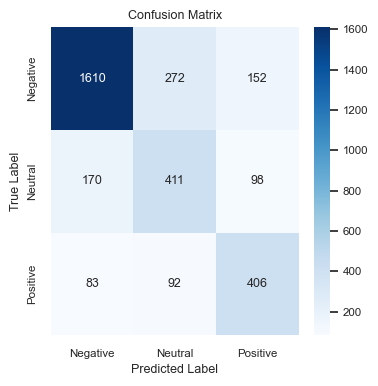

In [394]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix as cnf

def plot_confusion_matrix(conf_matrix, classes,cmap='Blues'):

    title = 'Confusion Matrix'

    plt.figure(figsize=(4,4))
    sns.set(font_scale=0.75)
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
plot_confusion_matrix(cnf(yts, nb.predict(x_test)), ['Negative','Neutral', 'Positive'])

In [395]:
tester =pd.read_csv('twitter_test.csv')

In [396]:
test = tester.text

In [397]:
test

0       @AmericanAir In car gng to DFW. Pulled over 1h...
1       @AmericanAir after all, the plane didn’t land ...
2       @SouthwestAir can't believe how many paying cu...
3       @USAirways I can legitimately say that I would...
4       @AmericanAir still no response from AA. great ...
                              ...                        
3655    @USAirways Been stuck for 40+ minutes due to l...
3656    @USAirways 4 hours... 4 hours... FOUR HOURS.  ...
3657    Nice RT @VirginAmerica: The man of steel might...
3658    @AmericanAir Aww Thanks AA..DFW was on GMA up ...
3659    @united the lounge tells us they have no pillo...
Name: text, Length: 3660, dtype: object

In [398]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Initialize WordNet Lemmatizer
lemmatizer_test = WordNetLemmatizer()

# Tokenize the data
list_tokens_test = [word_tokenize(i) for i in test]

# Remove stop words and punctuation
list_tokens_test = [[word for word in sublist if word.lower() not in stop_words and word.isalnum()] for sublist in list_tokens_test]


In [399]:
clean_doc_test = []
for doc in list_tokens_test:
    cleantst = [lemmatizer_test.lemmatize(word.lower()) for word in doc]
    clean_doc_test.append(cleantst)

In [400]:
clean_doc_test

[['americanair',
  'car',
  'gng',
  'dfw',
  'pulled',
  '1hr',
  'ago',
  'icy',
  'road',
  'aa',
  'since',
  '1hr',
  'ca',
  'reach',
  'arpt',
  'aa2450',
  'wat',
  '2'],
 ['americanair',
  'plane',
  'land',
  'identical',
  'worse',
  'condition',
  'grk',
  'according',
  'metars'],
 ['southwestair',
  'ca',
  'believe',
  'many',
  'paying',
  'customer',
  'left',
  'high',
  'dry',
  'reason',
  'flight',
  'cancelled',
  'flightlations',
  'monday',
  'bdl',
  'wow'],
 ['usairways',
  'legitimately',
  'say',
  'would',
  'rather',
  'driven',
  'cross',
  'country',
  'flown',
  'u',
  'airway'],
 ['americanair', 'still', 'response', 'aa', 'great', 'job', 'guy'],
 ['united',
  'developer',
  'flying',
  'tmrw',
  'morn',
  'min',
  'layover',
  'earlier',
  'flight',
  'layover',
  'move'],
 ['usairways', 'hello', 'anyone'],
 ['usairways',
  'husainhaqqani',
  'husain',
  'u',
  'shld',
  'protest',
  'well',
  'one',
  'ur',
  'party',
  'member',
  'rehman',
  'malik'

In [401]:
clean_doc_test = [" ".join(words) for words in clean_doc_test]


In [402]:
X_to_be_predicted =tfidf.transform(clean_doc_test)

In [403]:
y_predicted = nb.predict(X_to_be_predicted)

In [404]:
ypred=[]
for i in y_predicted:
    if i==0:
        ypred.append('neutral')
    elif i==-1:
        ypred.append('negative')
    else:
        ypred.append('positive')

In [405]:
ypred = np.array(ypred)

In [406]:
np.savetxt('PredictionsTwitter.csv', ypred, delimiter=',', fmt='%s')